In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
100% 5.20G/5.20G [03:03<00:00, 29.3MB/s]
100% 5.20G/5.20G [03:03<00:00, 30.5MB/s]


In [5]:
! mkdir data
! unzip -q skin-cancer-mnist-ham10000.zip -d data
! unzip -q /content/drive/MyDrive/HAM10000_segmentations_lesion_tschandl.zip -d data

In [6]:
! mkdir models

In [2]:
import albumentations as A
import time
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from PIL import Image
from transformers import ViTModel, ViTConfig
import torch.nn as nn
import copy
from albumentations.pytorch import ToTensorV2
import torch
import torch.nn.functional as Fun
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix



/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.17 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

Using device: cuda


In [7]:
DATA_DIR = 'data/'

METADATA_FILE = os.path.join(DATA_DIR, 'HAM10000_metadata.csv')
IMAGE_DIRS = [os.path.join(DATA_DIR, 'HAM10000_images_part_1'),
              os.path.join(DATA_DIR, 'HAM10000_images_part_2')]
MASK_DIR = os.path.join(DATA_DIR, 'HAM10000_segmentations_lesion_tschandl')

metadata = pd.read_csv(METADATA_FILE)

In [8]:
le = LabelEncoder()
metadata['dx_encoded'] = le.fit_transform(metadata['dx'])
num_classes = len(le.classes_)
print(f"Number of classes: {num_classes}")
print(le.classes_)
print(metadata['image_id'])

Number of classes: 7
['akiec' 'bcc' 'bkl' 'df' 'mel' 'nv' 'vasc']
0        ISIC_0027419
1        ISIC_0025030
2        ISIC_0026769
3        ISIC_0025661
4        ISIC_0031633
             ...     
10010    ISIC_0033084
10011    ISIC_0033550
10012    ISIC_0033536
10013    ISIC_0032854
10014    ISIC_0032258
Name: image_id, Length: 10015, dtype: object


In [9]:
train_df, test_df = train_test_split(metadata, test_size=0.2, stratify=metadata['dx'], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, stratify=train_df['dx'], random_state=42)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Testing samples: {len(test_df)}")

Training samples: 7210
Validation samples: 802
Testing samples: 2003


In [25]:
class SkinCancerDataset(Dataset):
    def __init__(self, dataframe, image_dirs, mask_dir, transform=None):
        """
        Args:
            dataframe (pd.DataFrame): DataFrame containing image information and labels.
            image_dirs (list): List of directories where images are stored.
            mask_dir (str): Directory where segmentation masks are stored.
            transform (callable, optional): Transformations to apply to the images.
            mask_transform (callable, optional): Transformations to apply to the masks.
        """
        self.dataframe = dataframe.reset_index(drop=True)
        self.image_dirs = image_dirs
        self.mask_dir = mask_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def apply_mask(self, image, mask):
        # focus on the lesion area of the image
        return image * np.expand_dims(mask, axis=0)

    def __getitem__(self, idx):
        # Extract image ID and label
        img_id = self.dataframe.loc[idx, 'image_id']
        label = self.dataframe.loc[idx, 'dx_encoded']

        # Find image path
        img_path = None
        for dir in self.image_dirs:
            potential_path = os.path.join(dir, f"{img_id}.jpg")
            if os.path.exists(potential_path):
                img_path = potential_path
                break
        if img_path is None:
            raise FileNotFoundError(f"Image {img_id} not found in specified directories.")

        # Find mask path
        mask_path = os.path.join(self.mask_dir, f"{img_id}_segmentation.png")
        if not os.path.exists(mask_path):
            raise FileNotFoundError(f"Mask for image {img_id} not found in {self.mask_dir}.")

        # Load image
        image = np.array(Image.open(img_path).convert('RGB'))

        # Load mask
        mask = np.array(Image.open(mask_path).convert('L'))  # Grayscale

        # Apply transformations and masking to the image
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        masked_image = self.apply_mask(image, mask)

        # Convert label to torch.long
        label = torch.tensor(label, dtype=torch.long)

        return image, label

In [27]:
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=20, p=0.5),
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

val_test_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

In [28]:
train_dataset = SkinCancerDataset(
    dataframe=train_df,
    image_dirs=IMAGE_DIRS,
    mask_dir=MASK_DIR,
    transform=train_transform
)

val_dataset = SkinCancerDataset(
    dataframe=val_df,
    image_dirs=IMAGE_DIRS,
    mask_dir=MASK_DIR,
    transform=val_test_transform
)

test_dataset = SkinCancerDataset(
    dataframe=test_df,
    image_dirs=IMAGE_DIRS,
    mask_dir=MASK_DIR,
    transform=val_test_transform
)

In [29]:
def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels.data)
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct.double() / total

    return epoch_loss, epoch_acc

def eval_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct.double() / total

    return epoch_loss, epoch_acc

In [38]:
BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")
print(f"Number of testing batches: {len(test_loader)}")

Number of training batches: 113
Number of validation batches: 13
Number of testing batches: 32


In [36]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
model.eval()
model = model.to(DEVICE)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [39]:
# Define optimizer and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Initialize variables for tracking the best model
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
num_epochs = 20

for epoch in range(num_epochs):
    print(f'\nEpoch {epoch+1}/{num_epochs}')
    print('-' * 10)

    # Training Phase
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, DEVICE)
    print(f'Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}')

    # Validation Phase
    val_loss, val_acc = eval_epoch(model, val_loader, criterion, DEVICE)
    print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

    # Check if this is the best model so far
    if val_acc > best_acc:
        best_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), 'best_vit_with_mask.pth')
        print(f'Best model updated with Val Acc: {best_acc:.4f}')

    # Step the scheduler
    scheduler.step()

print('\nTraining complete.')
print(f'Best Validation Accuracy: {best_acc:.4f}')

# Load the best model weights
model.load_state_dict(best_model_wts)


Epoch 1/20
----------
Train Loss: 0.8145 Acc: 0.7111
Val Loss: 0.7427 Acc: 0.7107
Best model updated with Val Acc: 0.7107

Epoch 2/20
----------
Train Loss: 0.6341 Acc: 0.7677
Val Loss: 0.6541 Acc: 0.7506
Best model updated with Val Acc: 0.7506

Epoch 3/20
----------
Train Loss: 0.5544 Acc: 0.8022
Val Loss: 0.5832 Acc: 0.7706
Best model updated with Val Acc: 0.7706

Epoch 4/20
----------
Train Loss: 0.4921 Acc: 0.8129
Val Loss: 0.5540 Acc: 0.8017
Best model updated with Val Acc: 0.8017

Epoch 5/20
----------
Train Loss: 0.4312 Acc: 0.8451
Val Loss: 0.5965 Acc: 0.7918

Epoch 6/20
----------
Train Loss: 0.3846 Acc: 0.8607
Val Loss: 0.5498 Acc: 0.7968

Epoch 7/20
----------
Train Loss: 0.3495 Acc: 0.8695
Val Loss: 0.5574 Acc: 0.8130
Best model updated with Val Acc: 0.8130

Epoch 8/20
----------
Train Loss: 0.2627 Acc: 0.9044
Val Loss: 0.5147 Acc: 0.8279
Best model updated with Val Acc: 0.8279

Epoch 9/20
----------
Train Loss: 0.2325 Acc: 0.9164
Val Loss: 0.5205 Acc: 0.8317
Best model up

<All keys matched successfully>

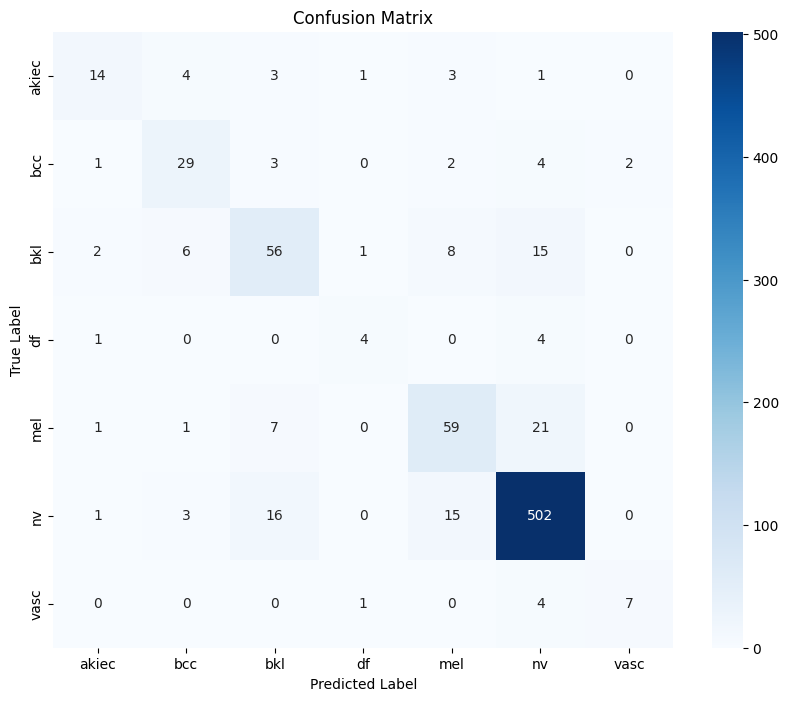

In [45]:
def plot_confusion_matrix(model, dataloader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Assuming you have a list of class names
class_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

plot_confusion_matrix(model, val_loader, DEVICE, class_names)